In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import tensorflow as tf

import itertools


## Early  preprocessing:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
df_all = pd.read_csv('/data/Data_Entry_2017.csv')
image_paths = {os.path.basename(x): x for x in 
               glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', df_all.shape[0])
df_all['path'] = df_all['Image Index'].map(image_paths.get)
df_all.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
3376,00000892_002.png,No Finding,2,892,45,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000892_002.png
15173,00003989_000.png,Cardiomegaly|Infiltration,0,3989,62,F,PA,2726,2991,0.143,0.143,NaN,/data/images_003/images/00003989_000.png
40691,00010563_004.png,Pleural_Thickening,4,10563,31,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010563_004.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

finding_names = list(set(l for findings in df_all["Finding Labels"] for l in findings.split('|')))
print("Finding labels that occur in the data set:\n\n\t"+'\n\t'.join(finding_names))


for finding_name in finding_names:
    df_all[finding_name] = df_all["Finding Labels"].apply(lambda x : int(finding_name in x.split('|')))

df_all.sample(3)

Finding labels that occur in the data set:

	Pneumonia
	Emphysema
	Atelectasis
	Pleural_Thickening
	No Finding
	Fibrosis
	Consolidation
	Effusion
	Nodule
	Edema
	Cardiomegaly
	Infiltration
	Mass
	Hernia
	Pneumothorax


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Consolidation,Effusion,Nodule,Edema,Cardiomegaly,Infiltration,Mass,Hernia,Pneumothorax
22288,00005912_000.png,Effusion,0,5912,51,F,AP,2500,2048,0.171,...,0,0,1,0,0,0,0,0,0,0
11224,00002927_001.png,No Finding,1,2927,50,F,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
68273,00016841_013.png,Atelectasis,13,16841,52,M,PA,2626,2717,0.143,...,0,0,0,0,0,0,0,0,0,0


## Create training and testing data:

In [4]:
# fraction of validation set that is negative cases. guessing what it might be in clinical setting.
frac_neg_valid = 0.9 

num_pos_all = sum(df_all['Pneumonia']==1)
num_pos_valid = int(0.2*num_pos_all)
num_neg_valid = int(frac_neg_valid/ (1-frac_neg_valid) * num_pos_valid)
num_pos_train = num_pos_all - num_pos_valid
num_neg_train = num_pos_train # training set will have 50-50 split of pos and neg cases

df_pos_all = df_all[df_all['Pneumonia']==1]
df_pos_all = df_pos_all.sample(frac=1.0) # shuffle
df_pos_valid = df_pos_all.iloc[:num_pos_valid]
df_pos_train = df_pos_all.iloc[num_pos_valid:]
assert(len(df_pos_train)==num_pos_train)

df_neg_all = df_all[df_all['Pneumonia']==0]
df_neg_all = df_neg_all.sample(frac=1.0) # shuffle
df_neg_valid = df_neg_all.iloc[:num_neg_valid]
df_neg_train_pool = df_neg_all.iloc[num_neg_valid:] # see make_df_train docstring below

# validation data is now fixed throughout training:
df_valid = pd.concat([df_pos_valid,df_neg_valid]).sample(frac=1.0)  

# training data has fixed set of positive cases, but let's allow switching out negative cases for fresh ones
def make_df_train(df_pos_train, df_neg_train_pool):
    """Return training data made using the fixed df_pos_train and a random selection
    of an equal number of entries from the fixed df_neg_train_pool. It will be a
    50-50 split between positive and negative cases, but the negative cases selected will vary each time 
    this function is called."""
    df_neg_train_pool = df_neg_train_pool.sample(frac=1.0) # shuffle
    df_neg_train = df_neg_train_pool[:num_neg_train]
    return pd.concat([df_pos_train,df_neg_train]).sample(frac=1.0)

# just sanity-checking the function make_df_train
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==1) == num_pos_train)
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==0) == num_neg_train)

print("The validation set consists of {} images, of which {} are positive cases.".format(
        num_pos_valid + num_neg_valid,
        num_pos_valid
    )
)
print("The training set will consist of {} images, of which {} are positive cases.".format(
        num_pos_train + num_neg_train,
        num_pos_train
    )
)

The validation set consists of 2860 images, of which 286 are positive cases.
The training set will consist of 2290 images, of which 1145 are positive cases.


# Now we can begin our model-building & training

image augmentation

In [5]:
idg_train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="constant",
    cval=0, # black background behind rotation/shift
    horizontal_flip=False, # see comment below
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

idg_valid = tf.keras.preprocessing.image.ImageDataGenerator()


I do not think horizontal flip makes sense as an augmentation here. It's true that there are AP and PA orientations, but those are front-back flipped which is not the same to an X-ray as a left-right flip (because X-rays will get obstructed by objects in a different order). Human anatomy is not left-right symmetric. Unless a patient has the rare conditon Situs Inversus, their heart will always be on the same side in the X-ray.

In [13]:
# The following column names are the ones whose binary labels our model will try to predict
# Pneumonia is first in the list, for convenience
# "No finding" doesn't need to be predicted, since it is represented by the case in which all outputs are 0

model_y_col = ['Pneumonia'] + [fn for fn in finding_names if fn not in ['No Finding', 'Pneumonia']]
print('\n'.join(model_y_col))

Pneumonia
Emphysema
Atelectasis
Pleural_Thickening
Fibrosis
Consolidation
Effusion
Nodule
Edema
Cardiomegaly
Infiltration
Mass
Hernia
Pneumothorax


In the following cell you can see that the training will be based on ALL the finding labels, not just pneumonia.
This way the network might learn more important higher level features than if it were just trained on pneumonia,
which I suspect can make it perform better on pneumonia.

Validation will just focus on pneumonia. In the end, I want the model that is best at pneumonia detection.

In [8]:
def make_dataframe_iterator_train():
    return idg_train.flow_from_dataframe(
        make_df_train(df_pos_train, df_neg_train_pool),
        directory=None,
        x_col="path",
        y_col=model_y_col,
        weight_col=None,
        target_size=(224, 224), # size expected by VGG16
        color_mode="rgb", # rgb channels expected by VGG16, even though img is grayscale
        classes=None,
        class_mode="raw",
        batch_size=32,
        shuffle=True, # I already shuffled it but sure
        seed=None,
        subset=None,
        interpolation="nearest",
        validate_filenames=True,
    )

dataframe_iterator_train = make_dataframe_iterator_train()

dataframe_iterator_valid = idg_valid.flow_from_dataframe(
    df_valid,
    directory=None,
    x_col="path",
    y_col="Pneumonia",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True, # I already shuffled it but sure
    seed=None,
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2290 validated image filenames.
Found 2860 validated image filenames.


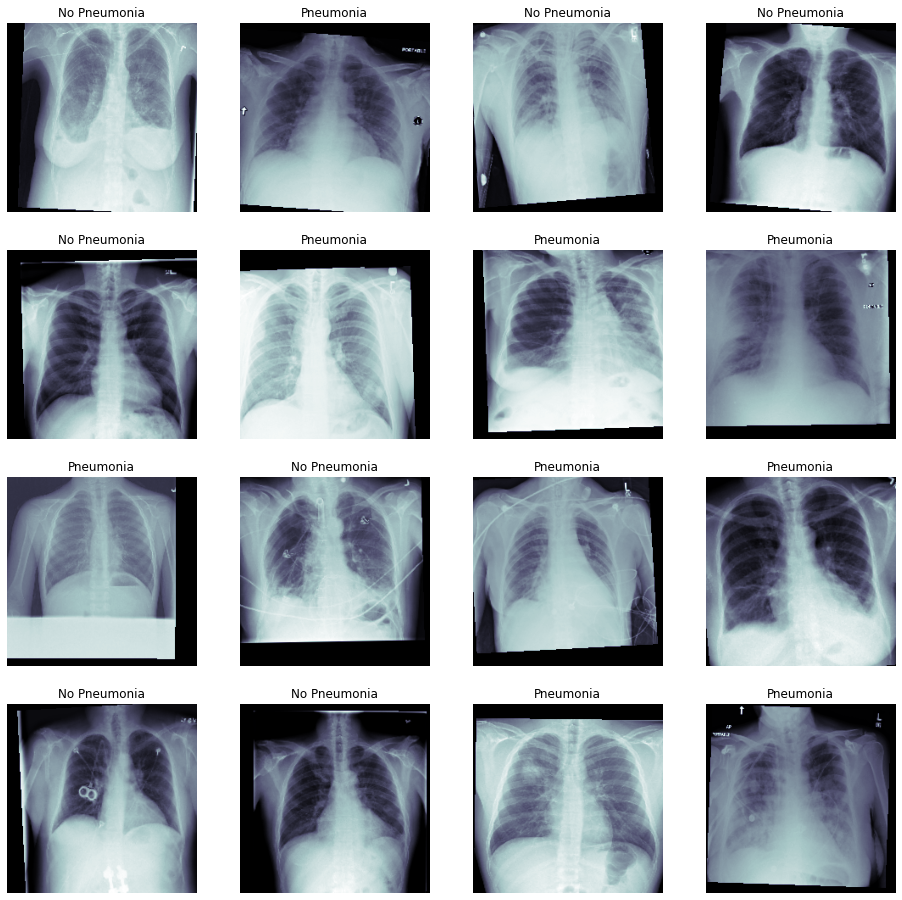

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(dataframe_iterator_train)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build model: 

In [15]:
vgg_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
)

In [16]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
for layer in vgg_model.layers[:19]: # 15 to freeze all but last conv layers, 19 to freez all conv layers
    layer.trainable = False

vgg_model_truncated = tf.keras.Model(vgg_model.input,vgg_model.layers[19].output)

vgg_model_truncated.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
inputs = tf.keras.Input(shape=(224,224,3), dtype='float32')
x = vgg_model_truncated(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(len(model_y_col))(x) # final output is logits, needs sigmoid to be applied still
outputs = x
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Model)                (None, 25088)             14714688  
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

In [69]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# The following loss function is a weighted mean of binary cross entropy losses
# The weighting is just to make pneumonia more important
# expected shape of y's is (batch size, number of labels)
def loss_fn(y_true, y_pred):
    pneumonia_loss = bce(y_true[:,0], y_pred[:,0])
    other_loss = sum(bce(y_true[:,i], y_pred[:,i]) for i in range(1,len(model_y_col)))
    
    # Tweak the weight of pneumonia here
    pneumonia_weight = 2.0
    return pneumonia_weight * pneumonia_loss + other_loss / (pneumonia_weight + len(model_y_col) - 1) 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [87]:
@tf.function
def train_on_batch(t_x,t_y):
    with tf.GradientTape() as tape:
        logits = model(t_x, training=True)
        loss = loss_fn(t_y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

@tf.function
def validation_loss(v_x,v_y):
    logits = model(v_x, training=False)[:,0] # take pneumonia prediction only
    loss = bce(v_y, logits)
    return loss

dataframe_iterator_valid

@tf.function
def inference_on_batch(x):
    logits = model(x, training=False)[:,0] # take pneumonia prediction only
    return tf.sigmoid(logits)

In [148]:
# Make a single big batch of validation data to use for metrics during training
# Will help to know when to stop training

val_during_training_x = np.empty(shape=(0,224,224,3), dtype='float32')
val_during_training_y = np.empty(shape=(0), dtype='float32')
for v_x, v_y in itertools.islice(dataframe_iterator_valid,8):
    val_during_training_x = np.concatenate((val_during_training_x, v_x))
    val_during_training_y = np.concatenate((val_during_training_y, v_y))

### Training

In [272]:
batches_per_epoch = len(dataframe_iterator_train)//32

t_losses_by_batch = []
tv_losses_by_epoch = []
min_v_loss = float('inf')
num_epochs_since_last_improvement = 0
patience = 6 # how many epochs of no improvement before we quit
best_model_weights = model.get_weights()
epoch = 0
while True:
    
    batch_count = 0
    dataframe_iterator_train = make_dataframe_iterator_train() # choose different negative images
    
    for t_x, t_y in dataframe_iterator_train:
        
        
        t_loss = train_on_batch(t_x,t_y).numpy()
        t_losses_by_batch.append(t_loss)
    
        print("Batch {} of epoch {}; training loss: {}".format(batch_count, epoch, t_loss))
        
        batch_count += 1
        if batch_count >= batches_per_epoch:
            break
    
    t_loss = np.mean(t_losses_by_batch[-batches_per_epoch:])
    v_loss = validation_loss(val_during_training_x,val_during_training_y).numpy()
    tv_losses_by_epoch.append([t_loss,v_loss])
    
    print("Epoch {} complete; average training loss {}; current validation loss: {}".format(
        epoch, t_loss, v_loss
    ))
    
    if v_loss < min_v_loss:
        min_v_loss = v_loss
        num_epochs_since_last_improvement = 0
        best_model_weights = model.get_weights()
    else:
        num_epochs_since_last_improvement += 1
    
    if num_epochs_since_last_improvement >= patience:
        break
        
    epoch += 1
    
model.set_weights(best_model_weights)

Found 2290 validated image filenames.
Batch 0 of epoch 0; training loss: 4.001652717590332
Batch 1 of epoch 0; training loss: 4.883050918579102
Epoch 0 complete; average training loss 4.442351818084717; current validation loss: 0.8181970119476318
Found 2290 validated image filenames.
Batch 0 of epoch 1; training loss: 5.034184455871582
Batch 1 of epoch 1; training loss: 3.9312851428985596
Epoch 1 complete; average training loss 4.482734680175781; current validation loss: 0.8555328249931335
Found 2290 validated image filenames.
Batch 0 of epoch 2; training loss: 3.515888214111328
Batch 1 of epoch 2; training loss: 4.216814041137695
Epoch 2 complete; average training loss 3.8663511276245117; current validation loss: 0.9320842027664185
Found 2290 validated image filenames.
Batch 0 of epoch 3; training loss: 2.9182498455047607
Batch 1 of epoch 3; training loss: 4.374595642089844
Epoch 3 complete; average training loss 3.646422863006592; current validation loss: 1.011173129081726
Found 2290

Todo next:

- (done) figure out a nice way to gather probabilities and labels in validation data as trying to do below
- (done) set up a cell, perhaps the below one, to take a threshold and print metrics like sensitivity and precision
- save best model during training using a patience value, and save model to json at end
- (done) work out the metrics they ask for below
- go back and play with learning rate and batch size
- go back and include all classes rather than just pneumonia, cutting down to pneum only for inference
- include AP and PA info into model

In [206]:
num_validation_batches = len(dataframe_iterator_valid)
probabilities = np.array([], dtype='float32')
ground_truth = np.array([], dtype='float32')
batch_count = 0
for v_x, v_y in dataframe_iterator_valid:
    probabilities = np.concatenate((probabilities, inference_on_batch(v_x)))
    ground_truth = np.concatenate((ground_truth, v_y))
    batch_count += 1
    if batch_count%10==0:
        print("worked through batch {}  of {}".format(batch_count, num_validation_batches))
    if batch_count >= num_validation_batches:
        break


worked through batch 10  of 90
worked through batch 20  of 90
worked through batch 30  of 90
worked through batch 40  of 90
worked through batch 50  of 90
worked through batch 60  of 90
worked through batch 70  of 90
worked through batch 80  of 90
worked through batch 90  of 90


In [207]:
def stats_for_threshold(threshold):
    probabilities >= threshold
    num_TP = ((probabilities >= threshold) & (ground_truth == 1.0)).sum()
    num_FP = ((probabilities >= threshold) & (ground_truth == 0.0)).sum()
    num_TN = ((probabilities < threshold) & (ground_truth == 0.0)).sum()
    num_FN = ((probabilities < threshold) & (ground_truth == 1.0)).sum()
    sensitivity = num_TP / (num_TP + num_FN)
    specificity = num_TN / (num_TN + num_FP)
    precision = num_TP / (num_TP + num_FP)
    false_pos_rate = num_FP/ (num_FP + num_TN)
    return sensitivity, specificity, precision, false_pos_rate

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

training history, ROC curve, and precision recall curve:

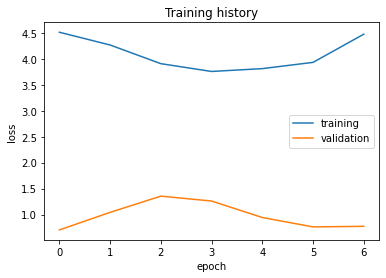

(Note that training and validation losses are computed differently and should not be compared to each other.)


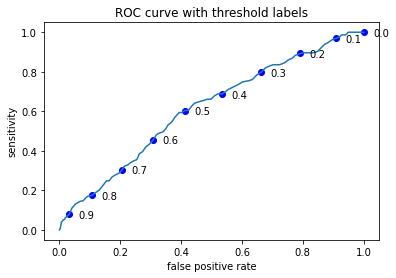

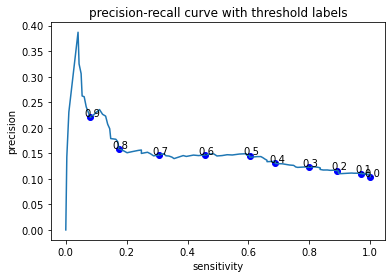

In [209]:
tv_losses_by_epoch_np = np.array(tv_losses_by_epoch)
plt.plot(tv_losses_by_epoch_np[:,0], label='training')
plt.plot(tv_losses_by_epoch_np[:,1], label='validation')
plt.title('Training history')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
print("(Note that training and validation losses are computed differently and should not be compared to each other.)")


thresholds = np.arange(0.0, 1.0, 0.01)
stats = np.array([stats_for_threshold(threshold) for threshold in thresholds])
sensitivities = stats[:,0]
specificities = stats[:,1]
precisions = stats[:,2]
fprs = stats[:,3]
not_nan_mask = (~np.isnan(precisions)) & (~np.isnan(sensitivities)) & (~np.isnan(fprs)) & (~np.isnan(specificities))
thresholds = thresholds[not_nan_mask]
sensitivities = sensitivities[not_nan_mask]
specificities = specificities[not_nan_mask]
precisions = precisions[not_nan_mask]
fprs = fprs[not_nan_mask]

plt.plot(fprs, sensitivities)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')
plt.title('ROC curve with threshold labels')
for i in range(0,len(stats),10):
    x = fprs[i]
    y = sensitivities[i]
    plt.scatter(x,y,color='blue')
    plt.text(x+0.03,y-0.02,str(round(thresholds[i],3)))
plt.show()

plt.plot(sensitivities, precisions)
plt.xlabel('sensitivity')
plt.ylabel('precision')
plt.title('precision-recall curve with threshold labels')
for i in range(0,len(stats),10):
    x = sensitivities[i]
    y = precisions[i]
    plt.scatter(x,y,color='blue')
    plt.text(x-0.02,y+0.002,str(round(thresholds[i],3)))
plt.show()

In [210]:
def optimal_threshold_for_fbeta(beta):
    fscores = np.array([[thres,(1+beta**2)*(prec*sens)/((beta**2)*prec+sens)]
                        for thres, prec, sens in zip(thresholds, precisions, sensitivities)
                        if not (prec==0.0 and sens==0.0)
                       ])
    return fscores[fscores[:,1].argmax(),0]

# Let's say we consider sensitivity to be twice as important as precision
threshold = optimal_threshold_for_fbeta(2)
threshold

0.28

In [211]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [212]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

NameError: name 'my_model' is not defined